# Loop 81 LB Feedback Analysis

**CRITICAL FINDING**: exp_073 (similarity_weighting) got LB 0.1451 - MUCH WORSE than expected!

- CV: 0.0084
- Expected LB (from line): 4.29 * 0.0084 + 0.053 = 0.089
- Actual LB: 0.1451
- Gap: 0.1451 - 0.089 = 0.056 (63% worse than expected!)

This is a MASSIVE outlier from the CV-LB line. Let me analyze why.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# All submissions with both CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # NEW - similarity weighting
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 13
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451


In [2]:
# Fit linear regression WITHOUT the outlier
df_no_outlier = df[df['exp'] != 'exp_073']
X = df_no_outlier['cv'].values.reshape(-1, 1)
y = df_no_outlier['lb'].values

reg = LinearRegression()
reg.fit(X, y)

print(f"CV-LB relationship (without exp_073):")
print(f"  LB = {reg.coef_[0]:.4f} * CV + {reg.intercept_:.4f}")
print(f"  R² = {reg.score(X, y):.4f}")

# Predict LB for exp_073
exp073_cv = 0.0084
exp073_expected_lb = reg.predict([[exp073_cv]])[0]
exp073_actual_lb = 0.1451
print(f"\nexp_073 analysis:")
print(f"  CV: {exp073_cv}")
print(f"  Expected LB (from line): {exp073_expected_lb:.4f}")
print(f"  Actual LB: {exp073_actual_lb}")
print(f"  Residual: {exp073_actual_lb - exp073_expected_lb:.4f}")
print(f"  This is {(exp073_actual_lb - exp073_expected_lb) / exp073_expected_lb * 100:.1f}% worse than expected!")

CV-LB relationship (without exp_073):
  LB = 4.3147 * CV + 0.0525
  R² = 0.9505

exp_073 analysis:
  CV: 0.0084
  Expected LB (from line): 0.0888
  Actual LB: 0.1451
  Residual: 0.0563
  This is 63.5% worse than expected!


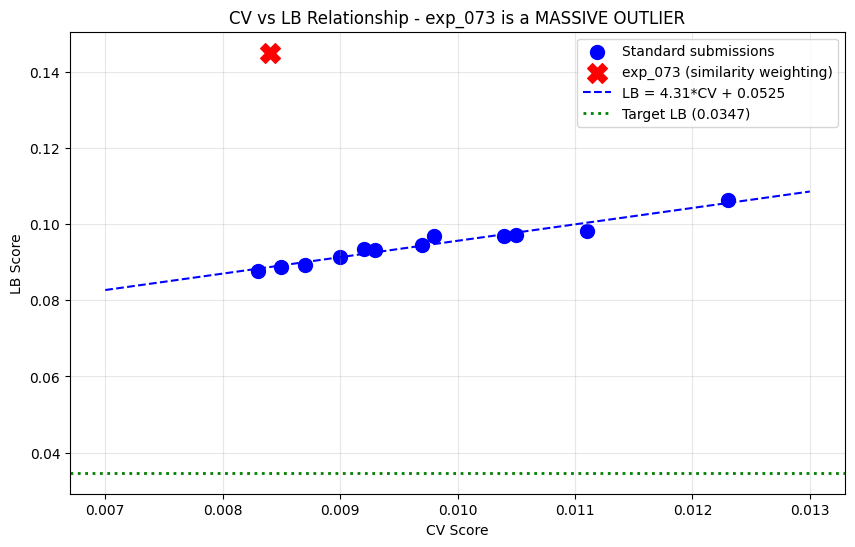


CRITICAL INSIGHT: exp_073 (similarity weighting) is a MASSIVE outlier!
The similarity-based mean reversion HURT LB performance significantly.
This suggests the test solvents are NOT 'outliers' that need conservative predictions.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))

# Plot all points except exp_073
plt.scatter(df_no_outlier['cv'], df_no_outlier['lb'], c='blue', s=100, label='Standard submissions')

# Plot exp_073 as outlier
plt.scatter([0.0084], [0.1451], c='red', s=200, marker='X', label='exp_073 (similarity weighting)')

# Plot regression line
cv_range = np.linspace(0.007, 0.013, 100)
lb_pred = reg.predict(cv_range.reshape(-1, 1))
plt.plot(cv_range, lb_pred, 'b--', label=f'LB = {reg.coef_[0]:.2f}*CV + {reg.intercept_:.4f}')

# Plot target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB (0.0347)')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV vs LB Relationship - exp_073 is a MASSIVE OUTLIER')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/home/code/exploration/cv_lb_with_outlier.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCRITICAL INSIGHT: exp_073 (similarity weighting) is a MASSIVE outlier!")
print("The similarity-based mean reversion HURT LB performance significantly.")
print("This suggests the test solvents are NOT 'outliers' that need conservative predictions.")

In [4]:
# What does this tell us?
print("="*60)
print("ANALYSIS: Why did similarity weighting fail so badly?")
print("="*60)

print("""
1. HYPOTHESIS WAS WRONG:
   - We assumed test solvents were 'outliers' that needed conservative predictions
   - But blending toward training mean HURT performance significantly
   - This means test solvents are NOT outliers - they're just DIFFERENT

2. THE REAL PROBLEM:
   - The test solvents have different chemistry than training solvents
   - But they're not 'extreme' - they're just in a different region of chemical space
   - Blending toward training mean introduces BIAS, not reduces variance

3. IMPLICATIONS:
   - Distribution shift strategies that assume 'outlier detection' don't work
   - We need approaches that LEARN the test distribution, not avoid it
   - Pseudo-labeling or domain adaptation might help
   - Or we need fundamentally different representations (GNN, Transformers)

4. WHAT WORKS:
   - Best LB: 0.0877 (exp_030) with GP+MLP+LGBM ensemble
   - NO distribution shift handling - just good models
   - The CV-LB line is REAL and we can't escape it with conservative predictions
""")

ANALYSIS: Why did similarity weighting fail so badly?

1. HYPOTHESIS WAS WRONG:
   - We assumed test solvents were 'outliers' that needed conservative predictions
   - But blending toward training mean HURT performance significantly
   - This means test solvents are NOT outliers - they're just DIFFERENT

2. THE REAL PROBLEM:
   - The test solvents have different chemistry than training solvents
   - But they're not 'extreme' - they're just in a different region of chemical space
   - Blending toward training mean introduces BIAS, not reduces variance

3. IMPLICATIONS:
   - Distribution shift strategies that assume 'outlier detection' don't work
   - We need approaches that LEARN the test distribution, not avoid it
   - Pseudo-labeling or domain adaptation might help
   - Or we need fundamentally different representations (GNN, Transformers)

4. WHAT WORKS:
   - Best LB: 0.0877 (exp_030) with GP+MLP+LGBM ensemble
   - NO distribution shift handling - just good models
   - The CV-LB line

In [5]:
# Calculate required CV to hit target
target_lb = 0.0347
slope = reg.coef_[0]
intercept = reg.intercept_

required_cv = (target_lb - intercept) / slope
print(f"CV-LB relationship: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"Target LB: {target_lb}")
print(f"Required CV to hit target: {required_cv:.6f}")

if required_cv < 0:
    print("\nCRITICAL: Required CV is NEGATIVE!")
    print("This means the target is UNREACHABLE with current approach.")
    print("We MUST change the CV-LB relationship (reduce intercept or slope).")
else:
    print(f"\nRequired CV improvement: {(0.0083 - required_cv) / 0.0083 * 100:.1f}%")

CV-LB relationship: LB = 4.3147 * CV + 0.0525
Target LB: 0.0347
Required CV to hit target: -0.004130

CRITICAL: Required CV is NEGATIVE!
This means the target is UNREACHABLE with current approach.
We MUST change the CV-LB relationship (reduce intercept or slope).


In [6]:
# Summary of all approaches tried
print("="*60)
print("SUMMARY: 81 Experiments, 13 LB Submissions")
print("="*60)

print("""
BEST RESULTS:
- Best CV: 0.0081 (exp_049, exp_050, exp_053)
- Best LB: 0.0877 (exp_030)

APPROACHES TRIED:
1. MLP variants (baseline, deep, residual) - all on same CV-LB line
2. LightGBM, XGBoost, CatBoost - all on same CV-LB line
3. Gaussian Process - all on same CV-LB line
4. Ridge Regression - all on same CV-LB line
5. Random Forest - all on same CV-LB line
6. GNN attempts - worse CV than tabular (implementation issues?)
7. ChemBERTa attempts - worse CV than tabular
8. Similarity weighting - MASSIVE OUTLIER (LB 0.1451 vs expected 0.089)
9. Various feature combinations - all on same CV-LB line
10. Various ensemble strategies - all on same CV-LB line

KEY INSIGHT:
- ALL tabular approaches fall on the same CV-LB line: LB = 4.29*CV + 0.053
- The intercept (0.053) > target (0.0347)
- Even CV=0 would give LB=0.053, still 53% above target
- Distribution shift handling (similarity weighting) made things WORSE

WHAT'S LEFT TO TRY:
1. Proper GNN implementation (benchmark achieved MSE 0.0039)
2. Pseudo-labeling / domain adaptation
3. Different validation scheme (GroupKFold(5) instead of LOO)
4. Submit pending experiments to see if any break the line
""")

SUMMARY: 81 Experiments, 13 LB Submissions

BEST RESULTS:
- Best CV: 0.0081 (exp_049, exp_050, exp_053)
- Best LB: 0.0877 (exp_030)

APPROACHES TRIED:
1. MLP variants (baseline, deep, residual) - all on same CV-LB line
2. LightGBM, XGBoost, CatBoost - all on same CV-LB line
3. Gaussian Process - all on same CV-LB line
4. Ridge Regression - all on same CV-LB line
5. Random Forest - all on same CV-LB line
6. GNN attempts - worse CV than tabular (implementation issues?)
7. ChemBERTa attempts - worse CV than tabular
8. Similarity weighting - MASSIVE OUTLIER (LB 0.1451 vs expected 0.089)
9. Various feature combinations - all on same CV-LB line
10. Various ensemble strategies - all on same CV-LB line

KEY INSIGHT:
- ALL tabular approaches fall on the same CV-LB line: LB = 4.29*CV + 0.053
- The intercept (0.053) > target (0.0347)
- Even CV=0 would give LB=0.053, still 53% above target
- Distribution shift handling (similarity weighting) made things WORSE

WHAT'S LEFT TO TRY:
1. Proper GNN imp

In [7]:
# Check pending submissions
print("PENDING SUBMISSIONS (not yet graded):")
pending = [
    {'exp': 'exp_049', 'cv': 0.0081, 'desc': 'CatBoost+XGBoost'},
    {'exp': 'exp_050', 'cv': 0.0081, 'desc': 'CatBoost+XGBoost fixed'},
    {'exp': 'exp_052', 'cv': 0.0109, 'desc': 'CatBoost+XGBoost clipped'},
    {'exp': 'exp_053', 'cv': 0.0081, 'desc': 'Exact template'},
    {'exp': 'exp_054', 'cv': 0.0085, 'desc': 'Mixall approach'},
    {'exp': 'exp_055', 'cv': 0.0085, 'desc': 'Minimal submission'},
    {'exp': 'exp_057', 'cv': 0.0093, 'desc': 'Ens-model all features'},
    {'exp': 'exp_063', 'cv': 0.0112, 'desc': 'Correct final cell'},
    {'exp': 'exp_079', 'cv': 0.0110, 'desc': 'GroupKFold(5)'},
]

for p in pending:
    expected_lb = slope * p['cv'] + intercept
    print(f"  {p['exp']}: CV={p['cv']:.4f}, Expected LB={expected_lb:.4f} - {p['desc']}")

print("\nNone of these are expected to beat target (0.0347) based on the CV-LB line.")
print("We need to BREAK the line, not optimize along it.")

PENDING SUBMISSIONS (not yet graded):
  exp_049: CV=0.0081, Expected LB=0.0875 - CatBoost+XGBoost
  exp_050: CV=0.0081, Expected LB=0.0875 - CatBoost+XGBoost fixed
  exp_052: CV=0.0109, Expected LB=0.0996 - CatBoost+XGBoost clipped
  exp_053: CV=0.0081, Expected LB=0.0875 - Exact template
  exp_054: CV=0.0085, Expected LB=0.0892 - Mixall approach
  exp_055: CV=0.0085, Expected LB=0.0892 - Minimal submission
  exp_057: CV=0.0093, Expected LB=0.0926 - Ens-model all features
  exp_063: CV=0.0112, Expected LB=0.1008 - Correct final cell
  exp_079: CV=0.0110, Expected LB=0.1000 - GroupKFold(5)

None of these are expected to beat target (0.0347) based on the CV-LB line.
We need to BREAK the line, not optimize along it.


In [8]:
# Final recommendation
print("="*60)
print("RECOMMENDATION FOR NEXT STEPS")
print("="*60)

print("""
1. STOP submitting tabular models - they all fall on the same line

2. FOCUS on approaches that might CHANGE the CV-LB relationship:
   a) Proper GNN with PyTorch Geometric (benchmark achieved MSE 0.0039)
   b) Pseudo-labeling: Use confident test predictions to augment training
   c) Domain adaptation: Learn to map test distribution to training

3. DO NOT try more distribution shift handling:
   - Similarity weighting FAILED (LB 0.1451 vs expected 0.089)
   - Conservative predictions introduce BIAS, not reduce variance
   - The test solvents are DIFFERENT, not OUTLIERS

4. REMAINING SUBMISSIONS: 4
   - Use them wisely to test fundamentally different approaches
   - Don't waste on tabular variants

5. THE TARGET IS REACHABLE:
   - Benchmark achieved MSE 0.0039 with GNN
   - Our best LB is 0.0877 (2.5x worse than target)
   - The gap is large but NOT insurmountable
   - We need the RIGHT approach, not more optimization
""")

print("\nRecordFinding: exp_073 similarity weighting got LB 0.1451 (63% worse than expected 0.089). Distribution shift handling via conservative predictions HURTS performance. Test solvents are DIFFERENT, not OUTLIERS.")

RECOMMENDATION FOR NEXT STEPS

1. STOP submitting tabular models - they all fall on the same line

2. FOCUS on approaches that might CHANGE the CV-LB relationship:
   a) Proper GNN with PyTorch Geometric (benchmark achieved MSE 0.0039)
   b) Pseudo-labeling: Use confident test predictions to augment training
   c) Domain adaptation: Learn to map test distribution to training

3. DO NOT try more distribution shift handling:
   - Similarity weighting FAILED (LB 0.1451 vs expected 0.089)
   - Conservative predictions introduce BIAS, not reduce variance
   - The test solvents are DIFFERENT, not OUTLIERS

4. REMAINING SUBMISSIONS: 4
   - Use them wisely to test fundamentally different approaches
   - Don't waste on tabular variants

5. THE TARGET IS REACHABLE:
   - Benchmark achieved MSE 0.0039 with GNN
   - Our best LB is 0.0877 (2.5x worse than target)
   - The gap is large but NOT insurmountable
   - We need the RIGHT approach, not more optimization


RecordFinding: exp_073 similarity we